## Lab 5: Recap on Dimensionality Reduction Techniques
You are required to use your implementations from previous labs, but for the new algorithms introduced today you can use external libraries.

In [1]:
import numpy as np
import pandas as pd
import gzip
import struct
import sklearn
import matplotlib.pyplot as plt
import torch

c:\Users\ilari\anaconda3\envs\tesi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Uploading the data and building the autoencoder
Download the ```fashion mnist``` dataset available at the following [link](https://github.com/zalandoresearch/fashion-mnist#get-the-data).

In [2]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
Xtrain = read_idx('../Datasets/fashion_mnist//train-images-idx3-ubyte.gz')
ytrain=read_idx('../Datasets/fashion_mnist/train-labels-idx1-ubyte.gz')

Xtest = read_idx('../Datasets/fashion_mnist//t10k-images-idx3-ubyte.gz')
ytest =read_idx('../Datasets/fashion_mnist/t10k-labels-idx1-ubyte.gz')

C:\Users\ilari\AppData\Local\Temp\ipykernel_18784\2859420377.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


In [4]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
Xtrain = Xtrain[:5000]
Xtest = Xtest[:100]

ytrain = ytrain[:5000]
ytest = ytest[:100]

In [6]:
print(Xtrain.shape)
print(Xtest.shape)

(5000, 28, 28)
(100, 28, 28)


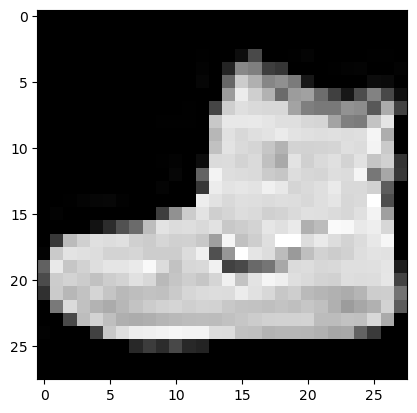

In [7]:
image = Xtrain[0]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

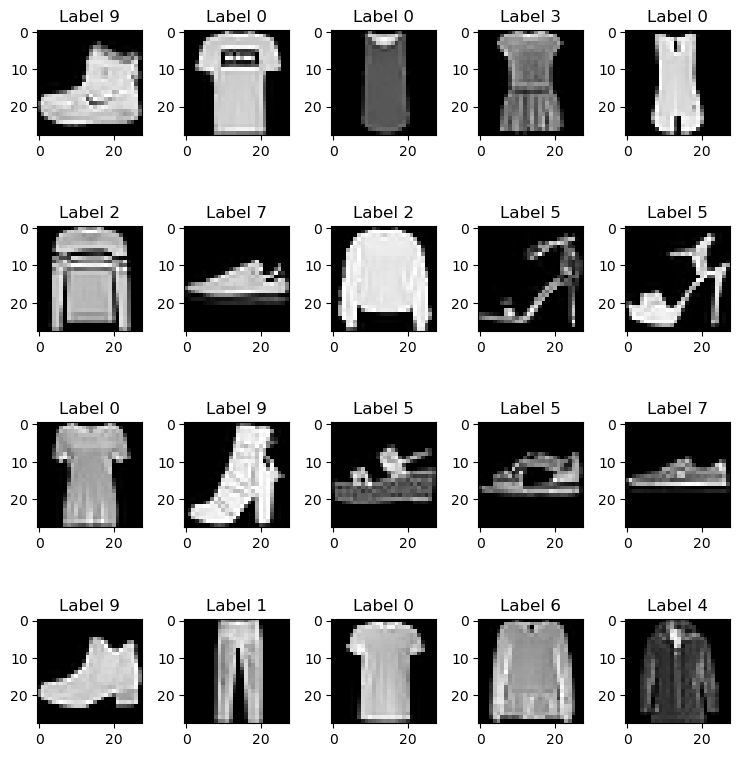

In [8]:
n_row = 4
n_col = 5

n=n_row * n_col
images=Xtrain[:n]
labels=ytrain[:n]

fig, axes=plt.subplots(n_row, n_col, figsize=(1.5*n_col, 2*n_row))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label {labels[i]}")
plt.tight_layout()
plt.show()

In [9]:
Xtrain = Xtrain/255
Xtest = Xtest/255 
#normalize it so that the values are in the [0,1] range

You can now work with the data, keeping in mind what preprocessing is required for each algorithm (eg. centering).

The following are costumization needed for ```pytorch``` and, specifically, the shape required for the convolutional layers.

In [10]:
input_shape = (1, 28, 28)

X_train = Xtrain.reshape(Xtrain.shape[0], *input_shape)
X_test = Xtest.reshape(Xtest.shape[0], *input_shape)

In [11]:
X_train = torch.stack([torch.from_numpy(np.array(i)) for i in X_train])
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in X_test])

In [12]:
train_set = torch.utils.data.TensorDataset(X_train, X_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
test_set = torch.utils.data.TensorDataset(X_test, X_test)

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [14]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=(3,3))
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=(3,3))
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=(3,3))
        self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=(3,3))

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.conv1(x))
        x = torch.nn.functional.leaky_relu(self.conv2(x))
        x = torch.nn.functional.leaky_relu(self.conv3(x))
        x = torch.nn.functional.leaky_relu(self.conv4(x))
        return x

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 =  torch.nn.ConvTranspose2d(64, 32, kernel_size=(3,3))
        self.conv2 =  torch.nn.ConvTranspose2d(32, 16, kernel_size=(3,3))
        self.conv3 =  torch.nn.ConvTranspose2d(16, 8, kernel_size=(3,3))
        self.conv4 =  torch.nn.ConvTranspose2d(8, 1, kernel_size=(3,3))
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.conv1(x))
        x = torch.nn.functional.leaky_relu(self.conv2(x))
        x = torch.nn.functional.leaky_relu(self.conv3(x))
        x = torch.nn.functional.leaky_relu(self.conv4(x))
        x = self.sigmoid_activation(x)
        return x

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
model = Autoencoder()

In [17]:
model

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid_activation): Sigmoid()
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
loss_func = torch.nn.MSELoss()


In [21]:
def train(model, train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs=50):        
    l_train =[]
    l_val = []

    for epoch in range(num_epochs): 
        model.train()
        loss_tr=[]

        for step, (images_raw, images_out) in enumerate(train_loader):
            y = model(images_raw.float())
            loss = loss_func(images_out.float(), y)
            loss_tr.append(loss.detach().item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        loss_ts = []
        for step, (images_raw, images_out) in enumerate(val_loader):
            y = model(images_raw.float())
            loss = loss_func(images_out, y)       
            loss_ts.append(loss.detach().cpu().numpy())
        print(f"Epoch {epoch}, training_loss: {np.mean(loss_tr)}, validation_loss {np.mean(loss_ts)}")
        scheduler.step()

        l_train.append(np.mean(loss_tr))
        l_val.append(np.mean(loss_ts))
    
    return l_train, l_val


In [23]:
USE_PRETRAINED_MODEL=True

if USE_PRETRAINED_MODEL:
    model.load_state_dict(torch.load('autoencoder.pt'))
    print("Model loaded")
else:
   l_train , l_val = train(model, train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs=100)
   torch.save(model.state_dict(), 'autoencoder1.pt')
   print("Model saved")


Epoch 0, training_loss: 0.011387800273951143, validation_loss 0.011338338357912339
Epoch 1, training_loss: 0.01128632394829765, validation_loss 0.01125846468254137
Epoch 2, training_loss: 0.011254920857027173, validation_loss 0.011277285289216163
Epoch 3, training_loss: 0.011239512066822499, validation_loss 0.011133766253984389
Epoch 4, training_loss: 0.011271678929915652, validation_loss 0.011487351676473828
Epoch 5, training_loss: 0.011685911100357771, validation_loss 0.010959550700056662
Epoch 6, training_loss: 0.01107661338755861, validation_loss 0.010952672001776218
Epoch 7, training_loss: 0.01095401489874348, validation_loss 0.01113841996728187
Epoch 8, training_loss: 0.011125265358714387, validation_loss 0.010794338437967328
Epoch 9, training_loss: 0.010850502556422725, validation_loss 0.010985856452668922
Epoch 10, training_loss: 0.01082009801757522, validation_loss 0.010732096531844534
Epoch 11, training_loss: 0.010714108648244292, validation_loss 0.010583162115363335
Epoch 12

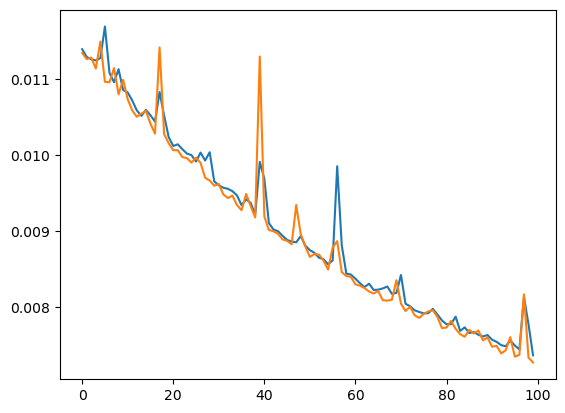

In [24]:
plt.plot(l_train)
plt.plot(l_val)
plt.show()